# Практика 5. Настройка модели с помощью Optuna

Подбирать параметры можно методом полного перебора по сетке (`GridSearchCV`) и случайный перебором значений из заданного распределения (`Random Search`).
Хотя `Random Search` уже значительно ускоряет процесс поиска, мы можем пропустить набор гиперпараметров, при котором модель показывает лучшее качество.<br><br>

Поэтому был реализован метод Оптимизации Байеса, который в начале запускает `Random Search`, потом начинаем чаще проверять в тех местах, рядом с которыми модель показала лучшую точность.


В `Optuna` присутствуют 2 базовые сущности:
1. `Study`: оптимизация, базирующаяся на `Objective` функции.
В `Objective` функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optun'ой много раз для подбора лучших параметров.
2. `Trial`: одно выполнение `Objective` функции.
В `trial` обьекте мы передаем параметры для "перебора", используя для каждого типа свой метод. К примеру

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы.
param = trial.suggest_float('param', 0, 1.5) 

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)

#### Параметры поиска:


* Целевая функция: Определяется пользователем и принимает на вход набор гиперпараметров и возвращает значение целевой функции.
* Пространство поиска: Определяется с помощью классов np.Float, np.Int, np.Categorical и других. Указывает возможные значения для каждого гиперпараметра.
* Оптимизатор: Выбирается из доступных в Optuna оптимизаторов.
* Количество испытаний: Максимальное количество испытаний, которые будут выполнены.
* Дополнительные параметры: Могут включать в себя списки случайной генерации, методы ранней остановки и другие.

#### Атрибуты:

* Параметры: Значения гиперпараметров для данного испытания.
* Значение целевой функции: Результат вычисления целевой функции для данного набора гиперпараметров.
* Номер испытания: Порядковый номер испытания в исследовании.
* Статус: Может быть RUNNING, COMPLETE, PRUNED и т.д.

Рассмотрим пример работы с Optuna

In [ ]:
!pip install optuna

In [4]:
import optuna

def objective(trial):
    # Задаем пространство поиска
    k1 = trial.suggest_float("k1", -10, 10)
    k2 = trial.suggest_int("k2", -10, 10)

    ## 
    # Вычисляем значение целевой функции
    return (k1 - 2)**2 + k2**2

# Создаем исследование. Ищем минимальное значение функции
study = optuna.create_study(direction="minimize")

# Запускаем оптимизацию для 100 экспериментов
study.optimize(objective, n_trials=100)

# Получаем лучшие найденные гиперпараметры
best_params = study.best_params
print(best_params)

[I 2025-10-07 12:18:50,200] A new study created in memory with name: no-name-979e2d34-f7d7-4d06-a8a6-4c7cb21ed2f4
[I 2025-10-07 12:18:50,202] Trial 0 finished with value: 38.80788995791569 and parameters: {'k1': 7.459660241985365, 'k2': 3}. Best is trial 0 with value: 38.80788995791569.
[I 2025-10-07 12:18:50,202] Trial 1 finished with value: 15.13362730838329 and parameters: {'k1': 4.476616100323845, 'k2': 3}. Best is trial 1 with value: 15.13362730838329.
[I 2025-10-07 12:18:50,203] Trial 2 finished with value: 45.80542512764553 and parameters: {'k1': 8.693685466739943, 'k2': 1}. Best is trial 1 with value: 15.13362730838329.
[I 2025-10-07 12:18:50,203] Trial 3 finished with value: 191.9472723569765 and parameters: {'k1': -9.31137800433601, 'k2': 8}. Best is trial 1 with value: 15.13362730838329.
[I 2025-10-07 12:18:50,204] Trial 4 finished with value: 31.61502598373148 and parameters: {'k1': 4.571969281257356, 'k2': 5}. Best is trial 1 with value: 15.13362730838329.
[I 2025-10-07 12

{'k1': 1.948421018885883, 'k2': 0}


В Optuna имеются методы визуализации экспериментов:

In [2]:
# Визуализируем значение гиперпараметров и функции
optuna.visualization.plot_slice(study)

In [3]:
# визуализируем значение функции
optuna.visualization.plot_optimization_history(study)

In [2]:
# Лучшие параметры
study.best_params

{'k1': 1.9276629464295907, 'k2': 0}

## Практика

In [5]:
import numpy as np
import optuna

from sklearn.datasets import load_diabetes
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [6]:
# данные для обучения можно использовать как глобальные, так и загружать локально
def objective(trial):
    data, target = load_diabetes(return_X_y=True) 
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25, random_state=42)
     
    # Define hyperparameters to be optimized
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    d_tree = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
    d_tree.fit(X=train_x, y=train_y)
    preds = d_tree.predict(test_x)
    mae = metrics.mean_absolute_error(test_y, preds)

    return mae


In [7]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
 
print('Количество экспериментов:', len(study.trials))
print('Лучший эксперимент:', study.best_trial.params)

[I 2025-10-07 12:32:01,186] A new study created in memory with name: no-name-aca98e36-951c-44f5-b931-6edf69ee0421
[I 2025-10-07 12:32:01,213] Trial 0 finished with value: 52.72469221527193 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 52.72469221527193.
[I 2025-10-07 12:32:01,217] Trial 1 finished with value: 50.904121644701355 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 50.904121644701355.
[I 2025-10-07 12:32:01,222] Trial 2 finished with value: 51.53304910804911 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 50.904121644701355.
[I 2025-10-07 12:32:01,226] Trial 3 finished with value: 54.204976404976414 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 50.904121644701355.
[I 2025-10-07 12:32:01,230] Trial 4 finished with value: 47.03278654

Количество экспериментов: 100
Лучший эксперимент: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5}


In [16]:
best_param = study.best_trial.params
print(best_param)

{'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5}


In [17]:
data, target = load_diabetes(return_X_y=True) 
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25, random_state=42)
d_tree = DecisionTreeRegressor(**best_param, random_state=42)
d_tree.fit(X=train_x, y=train_y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=3,
                      random_state=42)

In [ ]:
# Вычислим коэфициент детерминантности для модели 
print(f"Train")
y_pred = d_tree.predict(X=train_x)
r2_score = metrics.r2_score(y_true=train_y, y_pred=y_pred)
print(f"R2 = {r2_score}")
# и абсолютную ошибку отклонения
mae = metrics.mean_absolute_error(y_true=train_y, y_pred=y_pred)
print(f"MAE = {mae}")

print(f"TEST")
y_pred = d_tree.predict(X=test_x)
r2_score = metrics.r2_score(y_true=test_y, y_pred=y_pred)
mae = metrics.mean_absolute_error(y_true=test_y, y_pred=y_pred)
print(f"R2 = {r2_score}")
print(f"MAE = {mae}")

Train
R2 = 0.5754371097306068
MAE = 40.35516144436931
TEST
R2 = 0.45991539327002706
MAE = 43.56939176434806


In [8]:
data, target = load_diabetes(return_X_y=True) 
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25, random_state=42)

d_tree = DecisionTreeRegressor(random_state=42)
d_tree.fit(X=train_x, y=train_y)

DecisionTreeRegressor(random_state=42)

In [9]:
# Вычислим коэфициент детерминантности для модели 
print(f"Train")
y_pred = d_tree.predict(X=train_x)
r2_score = metrics.r2_score(y_true=train_y, y_pred=y_pred)
print(f"R2 = {r2_score}")
# и абсолютную ошибку отклонения
mae = metrics.mean_absolute_error(y_true=train_y, y_pred=y_pred)
print(f"MAE = {mae}")

print(f"TEST")
y_pred = d_tree.predict(X=test_x)
r2_score = metrics.r2_score(y_true=test_y, y_pred=y_pred)
mae = metrics.mean_absolute_error(y_true=test_y, y_pred=y_pred)
print(f"R2 = {r2_score}")
print(f"MAE = {mae}")

Train
R2 = 1.0
MAE = 0.0
TEST
R2 = -0.07450922562649187
MAE = 58.83783783783784


## Практика 2

In [10]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [11]:
# Загрузка данных
from sklearn.datasets import load_diabetes

data = load_diabetes()
X = data.data
y = data.target

#Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
def objective(trial):
    # Define hyperparameters to be optimized
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Create the pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf
        ))
    ])

    # Train the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Evaluate the pipeline on the testing data
    score = pipeline.score(X_test, y_test)

    return score

In [13]:
# функция возвращает метрику accuracy, которую необходимо максимизировать, поэтому direction='maximize'
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-10-07 12:45:51,647] A new study created in memory with name: no-name-29cebbb4-6dfc-4bfc-a7fc-caa4448fdfb9
[I 2025-10-07 12:45:51,849] Trial 0 finished with value: 0.36004414120283446 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.36004414120283446.
[I 2025-10-07 12:45:51,851] Trial 1 finished with value: 0.3425319443693333 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.36004414120283446.
[I 2025-10-07 12:45:51,856] Trial 2 finished with value: 0.26258829469536726 and parameters: {'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.36004414120283446.
[I 2025-10-07 12:45:51,858] Trial 3 finished with value: 0.30772341064054265 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.36004414120283446.
[I 2025-10-07 12:45:51,862] Trial 4 finished with value: 0.

In [14]:
# обучим модель я лучшими гиперпараметрами
best_params = study.best_params

best_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(**best_params))
])

best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=5,
                                       min_samples_split=7))])

In [18]:
from sklearn import metrics


# Вычислим коэфициент детерминантности для модели 
print(f"Train")

print(f"R2 = {r2_score}")
y_pred = best_pipeline.predict(X_train)
r2_score = metrics.r2_score(y_true=y_train, y_pred=y_pred)
# и абсолютную ошибку отклонения
mae = metrics.mean_absolute_error(y_true=y_train, y_pred=y_pred)
print(f"MAE = {mae}")

print(f"TEST")
y_pred = best_pipeline.predict(X=X_test)
r2_score = metrics.r2_score(y_true=y_test, y_pred=y_pred)
print(f"R2 = {r2_score}")

mae = metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f"MAE = {mae}")

Train
R2 = 0.4389521569443703
MAE = 35.69296205079921
TEST
R2 = 0.4389521569443703
MAE = 43.41874259148909


In [ ]:
# выведем лучшие параметры
best_pipeline.get_params()

{'memory': None,
 'steps': [('imputer', SimpleImputer()),
  ('scaler', StandardScaler()),
  ('model',
   DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=9))],
 'verbose': False,
 'imputer': SimpleImputer(),
 'scaler': StandardScaler(),
 'model': DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=9),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__keep_empty_features': False,
 'imputer__missing_values': nan,
 'imputer__strategy': 'mean',
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__ccp_alpha': 0.0,
 'model__criterion': 'squared_error',
 'model__max_depth': 5,
 'model__max_features': None,
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 9,
 'model__min_weight_fraction_leaf': 0.0,
 'model__monotonic_cst': None,
 'model__random_state': None,
 'model__splitter': 'best'}

## Практика 3

In [19]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [23]:
# Загрузка данных
import pandas as pd

df = pd.read_csv("data/housing_small.csv", encoding='latin1')

df.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1.111027e+12,2016-08-09,1464.0,106.0,415.0,31680.0,...,1.0,2005,3.0,6.0,0.217,1.0,0.0,1.0,7.0,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1.111027e+12,2016-07-28,903.0,126.0,575.0,43436.0,...,1.0,2004,4.0,6.0,0.667,1.0,1.0,0.0,7.0,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1.111041e+12,2016-12-11,1271.0,48.0,1030.0,52021.0,...,4.0,2005,3.0,6.0,0.500,1.0,0.0,0.0,7.0,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1.111043e+12,2016-09-30,965.0,138.0,297.5,22202.0,...,1.0,2008,1.0,6.0,0.273,1.0,0.0,0.0,6.0,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1.111027e+12,2016-08-28,927.0,286.0,392.0,48396.0,...,4.0,1960,2.0,2.0,0.333,0.0,1.0,1.0,1.0,62588.0


### Анализ данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   url                  4000 non-null   object 
 1   id                   4000 non-null   int64  
 2   Lng                  4000 non-null   float64
 3   Lat                  4000 non-null   float64
 4   Cid                  4000 non-null   float64
 5   tradeTime            4000 non-null   object 
 6   DOM                  4000 non-null   float64
 7   followers            4000 non-null   float64
 8   totalPrice           4000 non-null   float64
 9   price                4000 non-null   float64
 10  square               4000 non-null   float64
 11  livingRoom           4000 non-null   int64  
 12  drawingRoom          4000 non-null   int64  
 13  kitchen              4000 non-null   float64
 14  bathRoom             4000 non-null   int64  
 15  floor                4000 non-null   o

In [ ]:
df.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1.111027e+12,2016-08-09,1464.0,106.0,415.0,31680.0,...,1.0,2005,3.0,6.0,0.217,1.0,0.0,1.0,7.0,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1.111027e+12,2016-07-28,903.0,126.0,575.0,43436.0,...,1.0,2004,4.0,6.0,0.667,1.0,1.0,0.0,7.0,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1.111041e+12,2016-12-11,1271.0,48.0,1030.0,52021.0,...,4.0,2005,3.0,6.0,0.500,1.0,0.0,0.0,7.0,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1.111043e+12,2016-09-30,965.0,138.0,297.5,22202.0,...,1.0,2008,1.0,6.0,0.273,1.0,0.0,0.0,6.0,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1.111027e+12,2016-08-28,927.0,286.0,392.0,48396.0,...,4.0,1960,2.0,2.0,0.333,0.0,1.0,1.0,1.0,62588.0


Описание данных
- url: the url which fetches the data
- id: the id of transaction
- Lng: and Lat coordinates, using the BD09 protocol.
- Cid: community id
- tradeTime: the time of transaction
- DOM: active days on market.Know more in https://en.wikipedia.org/wiki/Days_on_market
- followers: the number of people follow the transaction.
- totalPrice: the total price

- square: the square of house
- livingRoom: the number of living room
- drawingRoom: the number of drawing room
- kitchen: the number of kitchen
- bathroom the number of bathroom
- floor: the height of the house. I will turn the Chinese characters to English in the next version.
- buildingType: including tower( 1 ) , bungalow( 2 )，combination of plate and tower( 3 ), plate( 4 ).
- constructionTime: the time of construction
- renovationCondition: including other( 1 ), rough( 2 ),Simplicity( 3 ), hardcover( 4 )
- buildingStructure: including unknow( 1 ), mixed( 2 ), brick and wood( 3 ), brick and concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).
- ladderRatio: the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average.
elevator have ( 1 ) or not have elevator( 0 )
- fiveYearsProperty: if the owner have the property for less than 5 years,

Целевая переменная:
- total_price: the average price by square

### Удаляем столбцы, которые не будем использовать

Например, нам не понадобятся
1. Урл
2. ID
3. Широта и долгота: В целом их можно было бы использовать и расчитать удаленность от «Точек притяжения», дорогих районов и тд, но у нас и так есть параметр Disctrict, поэтому упростим себе задачу.
4. Community ID: В большинстве своем это разные значения
5. tradeTime
6. followers
7. DOM
8. price – цена за квадратный метр

In [ ]:
df.drop(["url", "id", "Lng", "Lat", "Cid", "tradeTime", "followers", "DOM", "price"], axis="columns", inplace=True)

### Анализируем NaN

In [ ]:
df.isna().sum()

url                     0
id                      0
Lng                     0
Lat                     0
Cid                     0
tradeTime               0
DOM                     0
followers               0
totalPrice              0
price                   0
square                  0
livingRoom              0
drawingRoom             0
kitchen                 0
bathRoom                0
floor                   0
buildingType           59
constructionTime        0
renovationCondition     0
buildingStructure       0
ladderRatio             0
elevator                0
fiveYearsProperty       0
subway                  0
district                0
communityAverage        2
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3940 entries, 0 to 3999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   totalPrice           3940 non-null   float64
 1   square               3940 non-null   float64
 2   livingRoom           3940 non-null   int64  
 3   drawingRoom          3940 non-null   int64  
 4   kitchen              3940 non-null   float64
 5   bathRoom             3940 non-null   int64  
 6   floor                3940 non-null   object 
 7   buildingType         3940 non-null   float64
 8   constructionTime     3940 non-null   object 
 9   renovationCondition  3940 non-null   float64
 10  buildingStructure    3940 non-null   float64
 11  ladderRatio          3940 non-null   float64
 12  elevator             3940 non-null   float64
 13  fiveYearsProperty    3940 non-null   float64
 14  subway               3940 non-null   float64
 15  district             3940 non-null   float6

### Преобразуем этаж в числовое значение

In [24]:
df["floor"]

0       Â¸Ã 26
1       Â¸Ã 22
2        ÃÃ 4
3       ÂµÃ 21
4        ÃÃ 6
         ...   
3995    ÃÃ 21
3996    ÃÃ 16
3997     Â¸Ã 6
3998    Â¸Ã 30
3999    Â¸Ã 16
Name: floor, Length: 4000, dtype: object

In [26]:
df["floor"] = df["floor"].str.extract('(\d+)').astype(int)

df["floor"]

AttributeError: Can only use .str accessor with string values!

In [ ]:
df[df['constructionTime']=="Ã\x8eÂ´Ã\x96Âª"]

,totalPrice,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
41,170.0,77.00,2,1,1.0,1,6,4.0,ÃÂ´ÃÂª,1.0,2.0,0.333,0.0,1.0,0.0,6.0,35347.0
82,360.0,146.90,3,2,1.0,2,7,4.0,ÃÂ´ÃÂª,4.0,2.0,0.500,0.0,1.0,0.0,6.0,37612.0
101,470.0,143.32,1,0,0.0,0,32,1.0,ÃÂ´ÃÂª,3.0,6.0,0.500,1.0,1.0,1.0,7.0,30864.0
158,580.0,281.85,5,2,1.0,3,6,4.0,ÃÂ´ÃÂª,3.0,2.0,0.500,0.0,1.0,0.0,6.0,39940.0
160,330.0,111.93,3,2,1.0,1,6,4.0,ÃÂ´ÃÂª,2.0,2.0,0.500,0.0,1.0,1.0,7.0,56752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754,128.0,40.98,1,1,1.0,1,5,4.0,ÃÂ´ÃÂª,3.0,2.0,0.500,0.0,1.0,0.0,6.0,28475.0
3767,292.0,60.96,1,1,1.0,1,16,1.0,ÃÂ´ÃÂª,4.0,6.0,0.214,1.0,1.0,1.0,7.0,67041.0
3808,421.5,58.42,2,1,1.0,1,16,1.0,ÃÂ´ÃÂª,3.0,6.0,0.286,1.0,1.0,1.0,8.0,84427.0
3978,198.0,60.00,2,1,1.0,1,5,4.0,ÃÂ´ÃÂª,3.0,2.0,0.333,0.0,1.0,0.0,7.0,35300.0


### Преобразуем год постройки в числовое значение

В таблицу попало следующее значения — "ÃÂ´ÃÂª"  
Из-за него не получается конвертировать признак в int. Поскольку не получается расшифровать это значение, давайте посмотрим на распределение данных и решим, чем можно заменить это значение.

c:\Users\aleks\.conda\envs\MO_ipynb_py311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 142 (\x8e) missing from current font.

c:\Users\aleks\.conda\envs\MO_ipynb_py311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 150 (\x96) missing from current font.



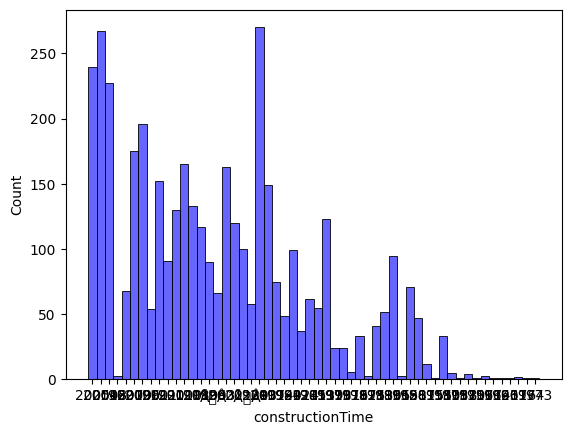

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a Histogram

sns.histplot(data=df, x='constructionTime', color='blue', alpha=0.6)
plt.show()

На графике видим, что выборка смещена влево.

 Преобразуем "ÃÂ´ÃÂª" в медианное значение

In [28]:
import numpy as np

df.loc[df["constructionTime"] == "Ã\x8eÂ´Ã\x96Âª", "constructionTime"] = np.nan

In [29]:
df["constructionTime"].fillna(df["constructionTime"].median(), inplace=True)

In [30]:
df["constructionTime"] = df["constructionTime"].astype(int)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   url                  4000 non-null   object 
 1   id                   4000 non-null   int64  
 2   Lng                  4000 non-null   float64
 3   Lat                  4000 non-null   float64
 4   Cid                  4000 non-null   float64
 5   tradeTime            4000 non-null   object 
 6   DOM                  4000 non-null   float64
 7   followers            4000 non-null   float64
 8   totalPrice           4000 non-null   float64
 9   price                4000 non-null   float64
 10  square               4000 non-null   float64
 11  livingRoom           4000 non-null   int64  
 12  drawingRoom          4000 non-null   int64  
 13  kitchen              4000 non-null   float64
 14  bathRoom             4000 non-null   int64  
 15  floor                4000 non-null   i

### Обучение модели

In [32]:
X,y = df.drop(columns = ["totalPrice"]), df["totalPrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
def objective(trial):
    # Define hyperparameters to be optimized
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Create the pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf
        ))
    ])

    # Train the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Evaluate the pipeline on the testing data
    score = pipeline.score(X_test, y_test)

    return score

In [34]:
# функция возвращает метрику accuracy, которую необходимо максимизировать, поэтому direction='maximize'
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-10-07 13:06:51,563] A new study created in memory with name: no-name-bed94b04-5335-4144-b823-0e70c87b83e0
[W 2025-10-07 13:06:51,566] Trial 0 failed with parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3} because of the following error: ValueError("Cannot use mean strategy with non-numeric data:\ncould not convert string to float: 'https://bj.lianjia.com/chengjiao/101091921617.html'").
Traceback (most recent call last):
  File "c:\Users\aleks\.conda\envs\MO_ipynb_py311\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\aleks\AppData\Local\Temp\ipykernel_35172\2336215577.py", line 19, in objective
    pipeline.fit(X_train, y_train)
  File "c:\Users\aleks\.conda\envs\MO_ipynb_py311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'https://bj.lianjia.com/chengjiao/101091921617.html'

In [ ]:
# обучим модель я лучшими гиперпараметрами
best_params = study.best_params
best_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(**best_params))
])

best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=5,
                                       min_samples_split=10))])

In [ ]:
from sklearn import metrics


# Вычислим коэфициент детерминантности для модели 
print(f"Train")
r2_score = metrics.r2_score(y_true=y_train, y_pred=y_train)
print(f"R2 = {r2_score}")
y_pred = best_pipeline.predict(X_train)
# и абсолютную ошибку отклонения
mae = metrics.mean_absolute_error(y_true=y_train, y_pred=y_train)
print(f"MAE = {mae}")

print(f"TEST")
r2_score = metrics.r2_score(y_true=y_test, y_pred=y_test)
print(f"R2 = {r2_score}")
y_pred = best_pipeline.predict(X=X_test)
mae = metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f"MAE = {mae}")

Train
R2 = 1.0
MAE = 0.0
TEST
R2 = 1.0
MAE = 43.41874259148909


In [ ]:
# выведем лучшие параметры
best_pipeline.get_params()

{'memory': None,
 'steps': [('imputer', SimpleImputer()),
  ('scaler', StandardScaler()),
  ('model',
   DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=10))],
 'verbose': False,
 'imputer': SimpleImputer(),
 'scaler': StandardScaler(),
 'model': DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=10),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__keep_empty_features': False,
 'imputer__missing_values': nan,
 'imputer__strategy': 'mean',
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__ccp_alpha': 0.0,
 'model__criterion': 'squared_error',
 'model__max_depth': 5,
 'model__max_features': None,
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 10,
 'model__min_weight_fraction_leaf': 0.0,
 'model__monotonic_cst': None,
 'model__random_state': None,
 'model__splitter': 'best'}

## Самостоятельная работа

- Доработать конвертирование признака floor

- Добавить разделение на числовые и категориальные признаки в Pipline

- Добавить шаг обработки категориальных признаков в Pipline

- Выполнить поиск гиперпараметров

- Обучить итоговую модель